In [38]:
%matplotlib inline

import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt

import shap

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [39]:
df = pd.read_csv('../xai.csv', index_col=False)
df.columns = [i.zfill(2) for i in df.columns]
df.drop(axis=1, labels = 'Unnamed: 0', inplace=True)
df.head(5)

,00,01,02,03,04,05,06,07,08,09,...,f7,f8,f9,fa,fb,fc,fd,fe,ff,Class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [40]:
X = df
y = df.pop('Class')

X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size = 0.2, random_state=42)

In [41]:
X_test.shape

(3642, 256)

In [42]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
print(classification_report(y_test, lr.predict(X_test)))

              precision    recall  f1-score   support

           1       0.85      0.88      0.87       114
           2       0.71      0.67      0.69       208
           3       0.54      0.51      0.53       219
           4       0.79      0.25      0.38       105
           5       0.86      0.86      0.86       785
           6       0.57      0.44      0.50       197
           7       0.90      0.68      0.78        66
           8       0.63      0.85      0.72       767
           9       0.75      0.11      0.19        55
          10       0.67      0.38      0.49       180
          11       0.80      0.79      0.79       121
          12       0.78      0.87      0.82       602
          13       0.84      0.70      0.76       131
          14       0.69      0.40      0.51        92

    accuracy                           0.73      3642
   macro avg       0.74      0.60      0.63      3642
weighted avg       0.74      0.73      0.72      3642



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [43]:
explainer = shap.Explainer(lr, X_train, feature_names=X_train.columns)
shap_values = explainer.shap_values(X_test.values)

In [44]:
print(len(shap_values))
#print(shap_values)

14


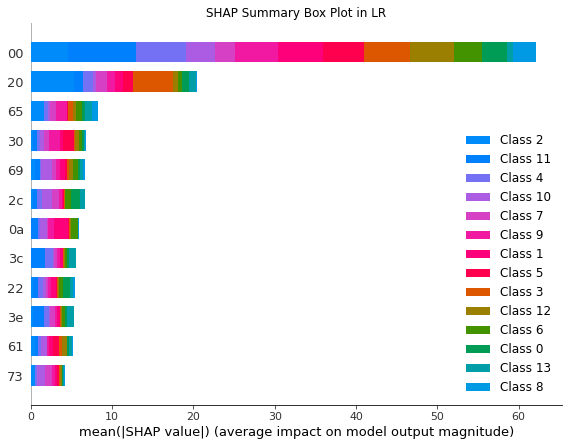

In [45]:
shap.initjs()



plt.title(f'SHAP Summary Box Plot in LR')
shap.summary_plot(shap_values, X_test,show=False, max_display=12)
plt.savefig('lr_summary.png')

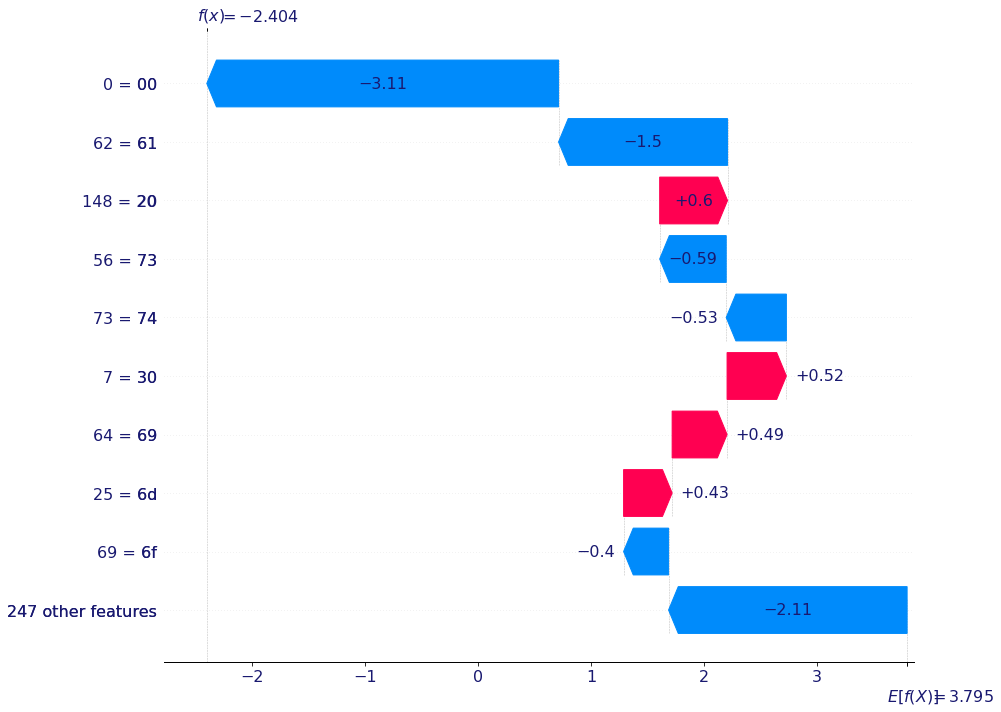

In [55]:
instance_index = 0 #index from the number of rows in the test data: 0-3642

# Obtain the class that the model predicted for the selected instance
predicted_class = lr.predict(X_test.iloc[instance_index:instance_index+1])[0]


expl = shap.Explanation(values=shap_values[predicted_class][instance_index],
                        base_values=explainer.expected_value[predicted_class],
                        data=X_test.iloc[instance_index],
                        feature_names=X_test.columns)

#shap values list range from 0-13
#expl = shap.Explanation(values=shap_values[0][instance_index],
                        #base_values=explainer.expected_value[0], #expected value for the first class: class 0
                        #data=X_test.iloc[instance_index],
                        #feature_names=X_test.columns)
            

  # fontsize of the figure title

# Generate the waterfall plot for the chosen instance using the Explanation object
shap.waterfall_plot(expl, show=False, max_display=10)


fig = plt.gcf()
ax = plt.gca()

# Iterate through text objects within the axes
for text_obj in ax.texts:
    text_obj.set_fontsize(16)
    if text_obj.get_color() == '#888888':  # This is a common color for grey text in plots
        text_obj.set_color('darkslategray')  # Dark grey color for better legibility
    else:
        text_obj.set_color('midnightblue') 

# If there are other texts not being caught by ax.texts, we can try a broader search
for text_obj in fig.findobj(match=lambda obj: isinstance(obj, plt.Text)):
    text_obj.set_fontsize(16)
    if text_obj.get_color() == '#888888':  # This is a common color for grey text in plots
        text_obj.set_color('darkslategray')  # Dark grey color for better legibility
    else:
        text_obj.set_color('midnightblue') 

plt.gcf().set_size_inches(14, 10)
plt.tight_layout()

plt.savefig('lr_waterfall_instance_{}_class_{}.png'.format(instance_index, predicted_class))


In [59]:
instance_index = 0

for class_index in range(len(shap_values)):
    
    # Get the SHAP values for the instance and class
    shap_values_instance_class = shap_values[class_index][instance_index]
    
    expl = shap.Explanation(values=shap_values_instance_class,
                            base_values=explainer.expected_value[class_index],
                            data=X_test.iloc[instance_index],
                            feature_names=X_test.columns)
    
    plt.title(f'SHAP Waterfall Plot for Instance {instance_index} and Class {class_index} in LR')
    
    shap.waterfall_plot(expl, show=False, max_display=10)
    
    fig = plt.gcf()
    ax = plt.gca()


    for text_obj in ax.texts:
        text_obj.set_fontsize(20)
        if text_obj.get_color() == '#888888':  # This is a common color for grey text in plots
            text_obj.set_color('darkslategray')  # Dark grey color for better legibility
        else:
            text_obj.set_color('midnightblue') 


    for text_obj in fig.findobj(match=lambda obj: isinstance(obj, plt.Text)):
        text_obj.set_fontsize(20)
        if text_obj.get_color() == '#888888':  
            text_obj.set_color('darkslategray')  
        else:
            text_obj.set_color('midnightblue') 

    plt.gcf().set_size_inches(14, 10)
    plt.tight_layout()
    
    plt.savefig('lr_waterfall_instance_{}_class_{}.png'.format(instance_index, class_index))
    plt.close()

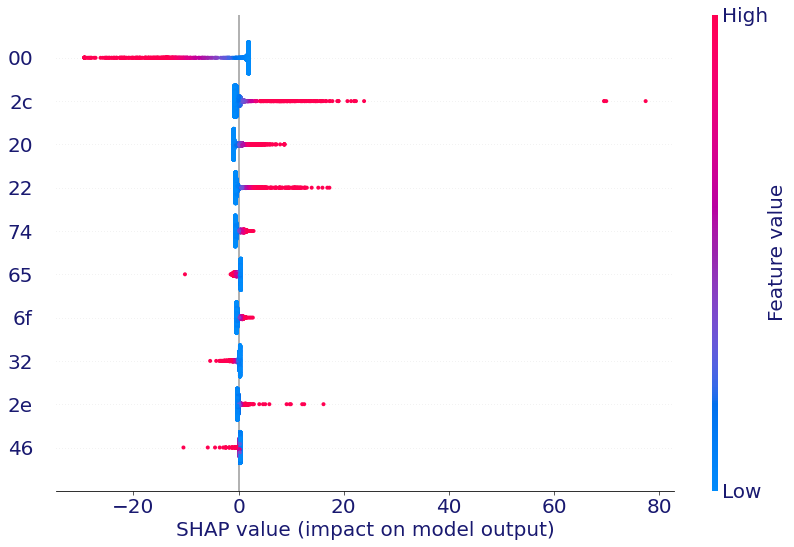

In [35]:
shap.initjs()

plt.rcParams.update({'font.size': 20})
shap.summary_plot(shap_values[0], X_test,show=False, max_display=10)

fig = plt.gcf()
ax = plt.gca()


for text_obj in ax.texts:
    text_obj.set_fontsize(20)
    if text_obj.get_color() == '#888888':  # This is a common color for grey text in plots
        text_obj.set_color('darkslategray')  # Dark grey color for better legibility
    else:
        text_obj.set_color('midnightblue') 

# If there are other texts not being caught by ax.texts, we can try a broader search
for text_obj in fig.findobj(match=lambda obj: isinstance(obj, plt.Text)):
    text_obj.set_fontsize(20)
    if text_obj.get_color() == '#888888':  # This is a common color for grey text in plots
        text_obj.set_color('darkslategray')  # Dark grey color for better legibility
    else:
        text_obj.set_color('midnightblue') 

plt.gcf().set_size_inches(12, 8)
plt.tight_layout()
plt.show()

In [36]:
shap.initjs()
for class_index in range(len(shap_values)): 
    
    plt.title(f'SHAP Beeswarm Plot for Class {class_index} in LR')
    
    shap.summary_plot(shap_values[class_index], X_test, plot_type="dot", max_display=10, show=False)
    
    fig = plt.gcf()
    ax = plt.gca()


    for text_obj in ax.texts:
        text_obj.set_fontsize(22)
        if text_obj.get_color() == '#888888':  # This is a common color for grey text in plots
            text_obj.set_color('darkslategray')  # Dark grey color for better legibility
        else:
            text_obj.set_color('midnightblue') 


    for text_obj in fig.findobj(match=lambda obj: isinstance(obj, plt.Text)):
        text_obj.set_fontsize(22)
        if text_obj.get_color() == '#888888':  
            text_obj.set_color('darkslategray')  
        else:
            text_obj.set_color('midnightblue') 

    plt.gcf().set_size_inches(12, 8)
    plt.tight_layout()
    
    plt.savefig('lr_beeswarm_instance_{}_class_{}.png'.format(instance_index, class_index))
    plt.close()
   
    

In [24]:
from lime import lime_tabular
import numpy as np

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),  
    feature_names=X_train.columns,    
    class_names=[str(cls) for cls in lr.classes_],  
    mode='classification' 
)

# Choose an instance to explain
instance_index = 0
instance = X_test.iloc[instance_index].to_numpy()


exp = explainer.explain_instance(
    data_row=instance,
    predict_fn=lr.predict_proba  # logistic regression predict_proba function
)


KeyboardInterrupt



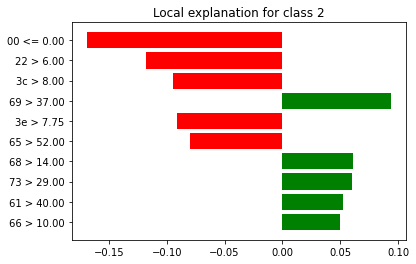

In [12]:
fig = exp.as_pyplot_figure()

fig.savefig('lime_report.png')

In [40]:
exp.as_list()

[('00 <= 0.00', -0.14998076481873915),
 ('22 > 6.00', -0.12373891615560215),
 ('3c > 8.00', -0.09683932218299546),
 ('69 > 37.00', 0.09296959388268278),
 ('3e > 7.75', -0.07637628587407823),
 ('65 > 52.00', -0.06988245472673864),
 ('73 > 29.00', 0.06951145118024052),
 ('68 > 14.00', 0.05863364321424397),
 ('66 > 10.00', 0.05261082858377229),
 ('fe <= 0.00', -0.047967214486560154)]